In [1]:
import folium
from folium.plugins import HeatMap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, PredefinedSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, balanced_accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import re
import string
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sodapy import Socrata
import xgboost as xgb
from joblib import dump, load
import datetime as date
import class_test

ModuleNotFoundError: No module named 'sodapy'

# Predicting if an Animal will be Rehomed using Government Data.

Below is a mini-project I started that attempts to predict if an animal taken in from Austin animal shelter will be re-homed in 30 days. I did this to better understand Tree + Ensemble methods in Sklearn.

- This project was inspired by a [mini-course on decision trees from AWS](https://github.com/aws-samples/aws-machine-learning-university-dte).
- Raw data is taken from [The City of Austin Texas's government data page](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm).

This project is ongoing, please excuse any grammatical mistakes or unfinished parts!

### Ongoing goals to add (As of 8/17/22):

1. Pull data via SODA API or create local SQL server to perform pulls. Problematic as SODA API won't let me pull "max rows."
2. Host code on AWS (or other cloud platform) to perform automatic execuction and deliver results of new animals to shelter.


# Context
 
The Austin Animal Shelter (AAS) takes in thousands of animals every year, yet transfers or rehomed 90%+ of the animals coming in. As a no kill shelter, AAS has a strong incentive to ensure all animals have a chance at finding a new home. With so many animals moving in and out of the shelter it would be beneficial for staff to get a daily update on which animals in the shelter would have a higher or lower chance of rehomed.  While staff have deep domain expertise, latent relationships between animal characteristics could be looked over in assigning probabilities of being rehomed. 
 
This project attempts to assign probabilities of rehoming for animals coming into the shelter. To do this I use income/outcome data from AAS, updated daily, to build multiple models to assign rehome probability to all animals. The hope is that staff would receive a daily report with all animals in their shelter with their propylites. Animals with high probabilities would be treated as business as usual - they would still benefit from staff attention, adoption events, etc... Animals with low probability could be promoted with free adoption fee's, highlights on their splash screen, or active outreach to find the animal a home.
 
# Summary of Approach/Results
 
To build this model I take AAS's outcome types:
 
- Adopted: The animal is adopted by a family
- Return to Owner: The animal is given back to the original owner
- Transfer: The animal is sent to a partner shelter
- Other: The animal passes away, is lost, or is put down for outstanding reasons.
 
I take rehomed as being adopted or returned to their owner. With this metric in mind, I use available features to build a prediction of probabilities. As AAS rehomes most of their animals (~65%) I recognize a slightly imbalanced data and use ROC-AUC scoring to try to find a model that combats such lopsidedness. In the end I use a random forest classifier to predict future animals brought in. 
 
I find a AUC score of 0.81, a balanced accuracy rate (using a 0.5 threshold) of 78%, and a accuracy rate of 81%. This constitutes as an improvement of ~70% over a dummy classifier that predicts being rehomed. 

## Data Intake + Prep

Cleaning is one of the most important aspects of any project. Below I attempt to:

1. Pull in data via API, create datasets
2. Find missing or bad data, these rows could skew our analysis, especially if features contain many missing values or behave in unexpected ways.
3. Apply cleaning rules to data.
4. Merged datasets to have a beginning endline dataset to run EDA over.

---


### 1. Grab Data


In [ ]:
# Define way to create raw data from API
def data_feeder(df):
    a = pd.DataFrame.from_records(df)
    a.columns = a.iloc[0]
    a = a[1:]
    # Annoying feature of from_records is that it replaces NaN with ''
    a = a.replace('', np.nan)
    return a


In [ ]:
# Call API to get Data
client = Socrata("data.austintexas.gov", 'HwnJIRk3Ph7NqQ0cPB0MOPkTF')
intake = client.get("wter-evkm", limit=99999999, content_type='csv')
outcome = client.get("9t4d-g238", limit=99999999, content_type='csv')

# Make data
intake_df = data_feeder(intake)
outcome_df = data_feeder(outcome)
geocoded_df = pd.read_csv('geocoded_locations.csv')


### 2. Clean Data before Analysis

Below I define a few functions to organize my data for easy EDA, this includes naming my columns with underscores and in lowercase for easy calls. I also harmonize column names across my intake and outcome dataframes. 

Lastly, I create a few new features for EDA and eventual model building, these include:
- name_avail: If the animal has a name when taken in, this could indicate the animal has a previous owner and would be rehomed quickly
- datetime: converting the datetime column from string to a datetime format for easy use.
- star_in_name: Some animals (both in the dataset and on AAS's website) have stars in their name. This means nothing to me, but there seems to be a reason as to why staff do this. I add this as a potential feature to work with.
- month: Take the specific month the animal was taken in.



In [ ]:
# Clean Data
def lower_case_col(columns):
    return columns.replace(" ", "_").lower()


def sort_for_merge(var, name):
    return var.sort_values(by=[name + '_datetime']).groupby(['animal_id']).cumcount()+1


def clean_up(dataframe, name):
    return (dataframe
            .rename(columns=lower_case_col)
            .assign(name_avail=np.where((dataframe.name.isna()) | (dataframe.name == dataframe.animal_id), 0, 1),
                    datetime=pd.to_datetime(dataframe.datetime),
                    star_in_name = np.where(dataframe.name.str.contains('[*]'), 1, 0),
                    month=lambda x: x.datetime.dt.month
                    )
            .rename(columns={'datetime': name+'_datetime'})
            .drop(['name'], axis=1)

            )


In [ ]:
# Apply to Data
intake_df_clean = clean_up(intake_df,'intake')
outcome_df_clean = clean_up(outcome_df,'outcome')


### 3. Merge Intake & Outcome Data:

Now merge the semi-cleaned data together so I can continue with feature engineering and EDA. To do this I first create merging variables.

The same animal can show up multiple times, however their intake and subsequent outcome are always in order. For instance if dog A has been intaken 5 times in our data, then they'll be in the outcome 5 times, if not the animal is still waiting for an outcome. I can't merge these multiple instances on ID and date as an animal will come in a different date it leaves, but I can sort on date in both dataframes and create a unique merge variable instead.


In [ ]:
def sort_for_merge(var):
    var['times_intaked'] = var.sort_values(
        by=([col for col in var.columns if 'datetime' in col])).groupby(['animal_id']).cumcount()+1


sort_for_merge(intake_df_clean)
sort_for_merge(outcome_df_clean)

# Now merge
merged_df = intake_df_clean.merge(outcome_df_clean[[
    'outcome_type',
    'animal_id',
    'outcome_datetime',
    'times_intaked']],
    on=['animal_id',
        'times_intaked'],
    how='outer',
    indicator=True)

# Okay most merged!
print(merged_df._merge.value_counts())

# lets just keep in the inner product
merged_df = merged_df[merged_df._merge == 'both']


### 4. Find bad/missing data:

Here I am looking for any columns that might be problematic to our analysis (many missing values, extreme values, or nonsensical values that require more digging).

I want to automate this, if we find a small amount of NaN's we should be fine to just drop them. If these NaN become a larger issues (lets say > %2) we need to pause and manually inspect what is going on.

It should be noted that this notebook is a little backwards, I was able to do a mix of EDA and bad data cleanup in unison but for clarity to an external audience I just separate the two. This means I found odd relationships later into EDA but came back up here to insert cleaning rules.


In [ ]:
# Let's make a function to output what's missing
def percent_missing(df):
    percent_nan = 100 * df.isnull().sum() / len(df)
    percent_nan = percent_nan[percent_nan > 0].sort_values()
    drop_list = percent_nan[(percent_nan < 2) & percent_nan != 0]
    if percent_nan.shape[0] == 0:
        print("No NA values, consider checking the data")
    else:
        print(percent_nan)
    return drop_list.index.to_list()


drop_list = percent_missing(merged_df)
merged_df = merged_df.dropna(subset=drop_list)

## EDA + Feature Engineering

This step attempts to combine multiple aspects of any data science project together:

1. Identify worthwhile features to use and determine what features to create.
2. Create new features. Many of the raw features given are not ready to run EDA over. I need to still fix and create features.
3. Perform EDA and identify any issues or interesting relationships.
4. Drop observations or clean features of interest.
5. Specify features types and transform as needed

Feature Engineering is an ongoing process however, so what is listed above is only a portion of what I do on this project. Moreover, this process is an overarching step of this project. Under the hood and behind the curtains lies hundreds of lines of depreciated code, useless features, and other analysis not included. Later on I will continue feature engineering by dummying our variables (after EDA).

---


### 1.Identify

First I need to think of what features in the intake data could potentially predict if an animal will be rehomed, I don't want to throw the whole kitchen sink of features in potentially adding noise to my analysis. Second, I need to understand and define "rehomed." What is the key performance metric I should use?

Much of this "Identify" comes during EDA or via simple inspection of my data. I already know by looking that intake Age is important, breed, and time of adoption.


### 2. Create

After Identifying what I could use in the intake data, I need to create additional features and retool existing ones to my liking. Some potential ideas I saw:

1. Seasonality might matter, having an animal come in near Christmas might spur higher adoptions.
2. Age needs to be standard across animals, lets turn it into months.
3. How should we deal with purebred and mixed animals?


In [ ]:
# Lets make age in terms of months
def age_to_num(var):
    num, date = var.split(' ')
    num = int(num)
    if 'year' in date:
        num = num*12
    elif 'week' in date:
        num = num/4
    elif 'day' in date:
        num = num/30
    else:
        num
    if num < 0:
        num = np.nan
    return(num)

#Add more
merged_df = (
    merged_df
    # Few more X's
    .assign(age=merged_df.age_upon_intake.apply(age_to_num),
            # Let's make a "purebred" variable for dogs. This should only really matter for dogs, as for cats "shorthair mix" & "shorthair" for a cat are identical. Moreover, what is the difference between a "cow" and "cow mix?"
            purebred=np.where((merged_df.animal_type == "Dog") & ~(
                merged_df.breed.str.contains("Mix|/")), 1, 0),
            days=(merged_df.outcome_datetime -
                  merged_df.intake_datetime) / np.timedelta64(1, 'D'),
            )
    # Start on Y's
    .assign(adopted=np.where(merged_df.outcome_type.str.contains('Adopt'), 1, 0),
            rehomed=np.where(merged_df.outcome_type.str.contains(
                'Adopt|Rto|Return to Owner'), 1, 0),
            rehomed_in_30_days=lambda x: np.where(
            (x.rehomed == 1) & (x.days <= 30), 1, 0)
            )
)

#Drop if age < 0 (We merged bad obs)
merged_df = merged_df[merged_df.age > 0]


In [ ]:
# First SnowballStemmer

# specify stop_words: words that can be ignored when simplifying our strings
stop_words = ["a", "an", "the", "this", "that", "is", "it", "to", "and"]

stemmer = SnowballStemmer('english')


def preProcessText(text):
    # lowercase and strip leading/trailing white space
    text = text.lower().strip()

    # remove HTML tags
    text = re.compile('<.*?>').sub('', text)

    # remove punctuation
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)

    # remove extra white space
    text = re.sub('\s+', ' ', text)

    return text


def lexiconProcess(text, stop_words, stemmer):
    filtered_sentence = []
    words = text.split(" ")
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(stemmer.stem(w))
    text = " ".join(filtered_sentence)

    return text


def cleanSentence(text, stop_words, stemmer):
    return lexiconProcess(preProcessText(text), stop_words, stemmer)


# Clean the text features
for c in ['breed', 'color', 'found_location', 'intake_condition', 'intake_type', 'sex_upon_intake']:
    print('Text cleaning: ', c)
    merged_df[c + '_cleaned'] = [cleanSentence(
        item, stop_words, stemmer) for item in merged_df[c].values]
    merged_df[c + '_cleaned'] = [cleanSentence(item, stop_words, stemmer)
                    for item in merged_df[c].values]


In [ ]:
#Clean up our data
merged_df=(merged_df
.astype({'animal_type':'category',
'month':'category',
'sex_upon_intake':'category',
'intake_condition':'category',
'intake_type':'category',
'found_location_cleaned':'string',
'animal_id': 'string',
'breed_cleaned': 'string',
'color_cleaned': 'string',
'purebred': 'int',
'name_avail':'int'})
)

## EDA


Lets get an idea of where animals are found with an interactive map:


In [ ]:
# Maps
def generateBaseMap(default_location=[30, -97.733330], default_zoom_start=10):
    base_map = folium.Map(location=default_location,
                          control_scale=True, zoom_start=default_zoom_start)
    return base_map


basemap = generateBaseMap()

folium.TileLayer('cartodbpositron').add_to(basemap)
folium.Marker(location=[30.2527847, -97.6926073],
              popup='Austin Animal Shelter',
              icon=folium.Icon(color='green', icon='info-sign')).add_to(basemap)
HeatMap(data=geocoded_df[['latitude', 'longitude']].groupby(['latitude', 'longitude']).sum(
).reset_index().values.tolist(), radius=8, max_zoom=13, name='Heat Map').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)
basemap


First lets plot animal age by type. As we can see there's a concerning amount of outliers by animal type in our data (that is observations 1.5\*IQR + 3Q). These outliers are a true part of the population, so I keep them. 


In [ ]:
# animal ages
ax = sns.boxplot(x="animal_type", y="age", showfliers=False, data=merged_df)
ax.set_ylabel("Age (Months)")
ax.set_xlabel("Animal Type")
ax.set_title("Average Ages of Animals (All)")



In [ ]:
rename_col = {'rehomed':'Rehomed',
'rehomed_in_30_days': 'Rehomed Within 30 Days',
'animal_type': 'Animal Type',
'intake_type': 'Intake Type',
'name_avail': "Name Available",
'star_in_name': "Star in Name",
'times_intaked': '# Intaken'}

(merged_df
.groupby(['animal_type'])
.mean()
.dropna()
.round(2)
.rename(columns=rename_col)
)

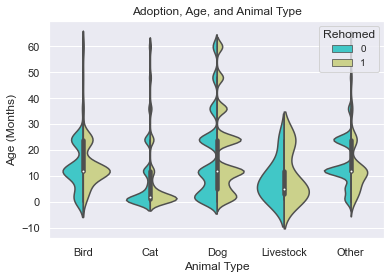

In [ ]:
#Adoption Chance by Age and Animal Type
ax = sns.violinplot(x='animal_type', y="age", data=merged_df[merged_df.age < 71],
                    hue='rehomed', split='True', palette='rainbow')
ax.set_ylabel("Age (Months)")
ax.set_xlabel("Animal Type")
ax.set_title("Adoption, Age, and Animal Type")
ax.legend(title="Rehomed",
          loc='best', fontsize='small')


In [ ]:
#Animal Type and Rehomed Proportions
(merged_df
.rename(columns=rename_col)
.pivot_table(index=['Animal Type'],
                                values=['Rehomed', 'Rehomed Within 30 Days'],
                                aggfunc=[np.mean, np.sum, len],
                                margins=True,
                                margins_name='Total')
.round(2)
)

mean                            sum                         \
0           Rehomed Rehomed Within 30 Days Rehomed Rehomed Within 30 Days   
Animal Type                                                                 
Bird           0.41                   0.39     279                    266   
Cat            0.53                   0.31   28298                  16497   
Dog            0.75                   0.64   59478                  50761   
Livestock      0.68                   0.32      17                      8   
Other          0.10                   0.08     780                    601   
Total          0.63                   0.48   88852                  68133   

                len                         
0           Rehomed Rehomed Within 30 Days  
Animal Type                                 
Bird            679                    679  
Cat           53513                  53513  
Dog           79215                  79215  
Livestock        25                     25  
Other          7499                   7499  
Total        140931                 140931

In [ ]:
#Intake Type and Rehomed %
(merged_df
.rename(columns=rename_col)
.pivot_table(index=['Intake Type'],
                                values=['Rehomed', 'Rehomed Within 30 Days'],
                                aggfunc=[np.mean, np.sum, len],
                                margins=True,
                                margins_name='Total')
.round(2)
)

mean                            sum  \
0                  Rehomed Rehomed Within 30 Days Rehomed   
Intake Type                                                 
Abandoned             0.69                   0.48     572   
Euthanasia Request    0.08                   0.04      20   
Owner Surrender       0.69                   0.52   20237   
Public Assist         0.81                   0.74    6889   
Stray                 0.63                   0.48   61124   
Wildlife              0.00                   0.00      10   
Total                 0.63                   0.48   88852   

                                              len                         
0                  Rehomed Within 30 Days Rehomed Rehomed Within 30 Days  
Intake Type                                                               
Abandoned                             401     835                    835  
Euthanasia Request                     11     259                    259  
Owner Surrender                     15090   29156                  29156  
Public Assist                        6316    8483                   8483  
Stray                               46306   96706                  96706  
Wildlife                                9    5492                   5492  
Total                               68133  140931                 140931

Text(0.5, 1.0, 'Count of Animal Types')

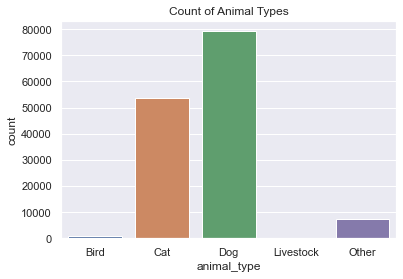

In [ ]:
#Total Counts
sns.countplot(x='animal_type', data=merged_df).set_title(
    "Count of Animal Types")


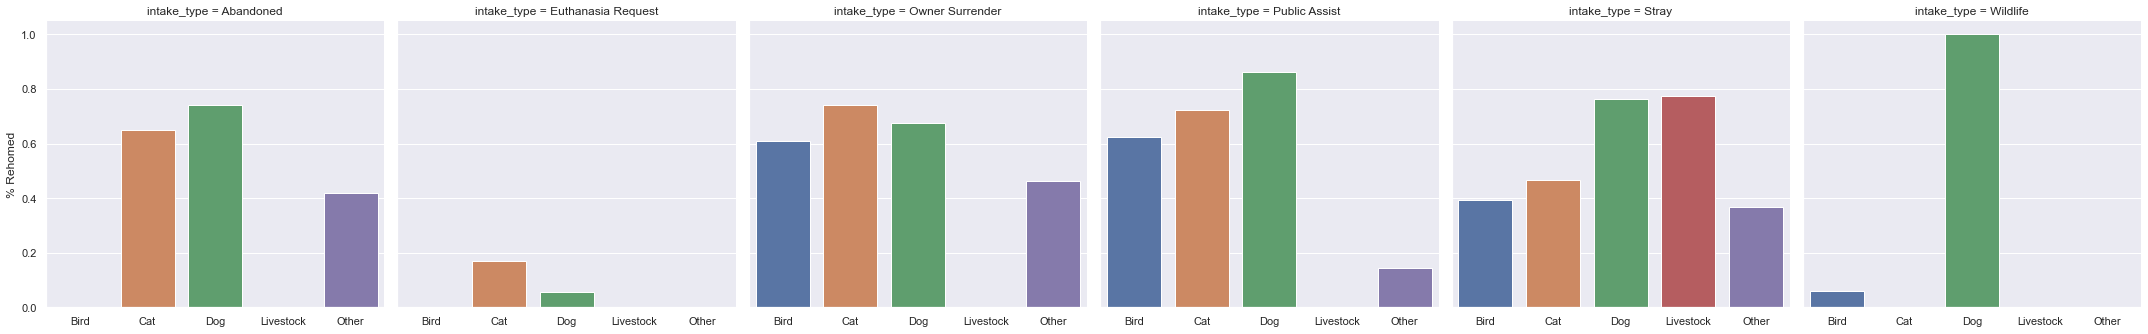

In [ ]:
#Rehomed by intake Type
sns.set(style="darkgrid")
ax = sns.catplot(
    x='animal_type',
    y='rehomed',
    col='intake_type',
    data=merged_df,
    kind='bar',
    ci=None
)
ax.set_ylabels('% Rehomed')
ax.set_xlabels('')


In [ ]:
#Rehomed by Month
sns.histplot(x='month',
            data=merged_df[merged_df.rehomed == 1])



In [ ]:
#Most frequent Animal by Type
def mode(x): return x.mode() if len(x) > 2 else np.array(x)


merged_df.groupby('animal_type')['breed'].agg(mode)


In [ ]:
#Number of unique breeds
merged_df.groupby('animal_type')['breed_cleaned'].nunique()

In [ ]:
#Avg number of times intaken by outcome type
(
merged_df
.groupby('animal_id', as_index=False)[['outcome_type','times_intaked']].max()
.sort_values('times_intaked', ascending=False)
.groupby('outcome_type', as_index=False)['times_intaked'].mean()
)



,outcome_type,times_intaked
0,Adoption,1.096756
1,Died,1.020968
2,Disposal,1.007874
3,Euthanasia,1.015086
4,Lost,1.000000
5,Missing,1.133333
6,Relocate,1.000000
7,Return to Owner,1.274336
8,Rto-Adopt,1.695349
9,Stolen,3.500000


In [ ]:
#Corr Matrix for Outcomes
(
    pd
    .get_dummies(data = merged_df, columns=['animal_type','intake_condition'])
    .corr()
    .reset_index()
    .loc[6:8]
    .style.background_gradient(axis=1, cmap='Greens')
)


,index,name_avail,star_in_name,times_intaked,age,purebred,days,adopted,rehomed,rehomed_in_30_days,animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Livestock,animal_type_Other,intake_condition_Aged,intake_condition_Agonal,intake_condition_Behavior,intake_condition_Feral,intake_condition_Injured,intake_condition_Med Attn,intake_condition_Med Urgent,intake_condition_Medical,intake_condition_Neonatal,intake_condition_Normal,intake_condition_Nursing,intake_condition_Other,intake_condition_Panleuk,intake_condition_Pregnant,intake_condition_Sick,intake_condition_Space
6,adopted,0.252807,-0.030197,0.011736,-0.143081,-0.019237,0.248282,1.000000,0.714415,0.378279,-0.016856,0.027956,0.054462,0.000388,-0.175651,-0.027061,-0.002486,0.000147,-0.011556,-0.085366,0.001861,-0.003515,0.000742,-0.028394,0.162546,-0.056081,-0.011734,-0.002486,-0.000668,-0.114411,-0.004971
7,rehomed,0.458469,-0.352332,0.110575,0.075696,0.065468,0.151042,0.714415,1.000000,0.740656,-0.031651,-0.164784,0.282549,0.001367,-0.258566,-0.000651,-0.003479,0.002450,-0.019165,-0.113150,0.000346,-0.004921,-0.001882,-0.044780,0.236713,-0.104285,-0.013822,0.002039,-0.005604,-0.171397,-0.006959
8,rehomed_in_30_days,0.308688,-0.396882,0.111355,0.106540,0.100008,-0.232325,0.378279,0.740656,1.000000,-0.012767,-0.274255,0.356732,-0.004357,-0.191326,0.005869,-0.002577,-0.002810,-0.016423,-0.115496,0.001692,-0.003644,-0.010760,-0.047177,0.238708,-0.137779,-0.015860,0.002753,-0.012543,-0.144795,-0.005154


## Feature Selection & Train Test Split


### Selecting Features + Outcome:

After EDA and some manual observation I believe I found a set of interesting features to use to predict adoption and rehoming. To simplfy this process down the road I will specify three type of features that I will use (and subsequently clean).

1. Numerical: Any feature that is continuos or ordinal, i.e. the feature is coded in such a way that high or lower values correspond to some implicit ordering or intensity. Think age, income, weight, size, etc..
2. Categorical: Any feature that can be broken in discrete values, however unlike ordinal, higher or lower values do not correspond to any ordering or intensity. Think color, breed, etc..
3. String: Any feature whose information is encoded as a string, where no well defined structure is present. Think name, address, review, etc..


In [ ]:
merged_df.columns

In [ ]:
num_feats = ['age', 'times_intaked', 'name_avail', 'purebred', 'star_in_name']
cat_feats = ['animal_type', 'month','sex_upon_intake_cleaned', 'intake_condition_cleaned', 'intake_type_cleaned']
str_feats = ['found_location_cleaned','color_cleaned', 'breed_cleaned']

x = num_feats + cat_feats + str_feats
y = 'rehomed'


In [ ]:
train_data, test_data = train_test_split(
    merged_df, test_size=0.2, shuffle=True, random_state=1, stratify=merged_df[y])

# From the test data further split into validation (we use throughout process) & test (use only at end)
val_data, test_data = train_test_split(
    test_data, test_size=0.5, shuffle=True, random_state=1, stratify=test_data[y])


## Process Data + Build Pipline

Below we will process our data (transform categorical into dummies and vectorize text data), then create a pipeline that can take in any new data and work it into our models seamlessly.

For numerical values we'll:

1. Impute any missing values with the mean (we saw very early on not many age's were missing, so a simple imputation will work well)
2. Standardize values (for non-tree models)

For categorical we'll:

1. Impute any missing with a unique categorical value (missing column = 1)
2. Transform into dummies with onehotencoder.

For Strings we'll:

1. Vectorize (just like creating dummies that equal 1 if the word exist in the row)


In [ ]:
def create_model(x = '', y = '' ,feats = [], model = '', tree = 0):
    """
    Creates a pipeline and fits model from Sklearn

    inputs
    ------------
    x: obs and covariates used in training
    y: outcome of obs in training
    feats: features you'd like to feed into the pipeline
    model: sklearn model you want to run
    tree: boolean, tree models use a different pipe (don't standardize the values)
    """
    #Break up features by dtype:
    num_feats = x[feats].select_dtypes('number').columns.to_list()
    cat_feats = x[feats].select_dtypes('category').columns.to_list()
    str_feats = x[feats].select_dtypes('string').columns.to_list()

    #Define Pipes
    if tree == 0:
        num_pipe = Pipeline([
            ('num_imputer', SimpleImputer(strategy='mean')),
            ('standardize', StandardScaler())
        ])
    else:
        num_pipe = Pipeline([
            ('num_imputer', SimpleImputer(strategy='mean')),
            ('standardize', StandardScaler())
        ])
        
    cat_pipe = Pipeline([
        ('cat_imputer', SimpleImputer(strategy='constant',
                                    fill_value='missing')),
        ('coder', OneHotEncoder(handle_unknown='ignore'))
    ])
    str_pipe0 = Pipeline([
        ('str', CountVectorizer(binary=True, max_features=150))
    ])
    str_pipe1 = Pipeline([
        ('str', CountVectorizer(binary=True, max_features=150))
    ])
    str_pipe2 = Pipeline([
        ('str', CountVectorizer(binary=True))
    ])

    if str_feats == []:
        #Create prep pipe depending on the feats you fed in
        prep = ColumnTransformer([
        ('num', num_pipe, num_feats),
        ('cat', cat_pipe, cat_feats),
        ])
    else:
        prep = ColumnTransformer([
        ('num', num_pipe, num_feats),
        ('cat', cat_pipe, cat_feats),
        ('str0', str_pipe0, str_feats[0]),
        ('str1', str_pipe1, str_feats[1]),
        ('str2', str_pipe2, str_feats[2])

        ])

    final = Pipeline([
        ("prep", prep),
        ("model", model)
    ])


    #fit
    final.fit(x, y)
    return final


### Specify Models to Run


In [ ]:
# Get train data to train the network
X_train = train_data[x]
y_train = train_data[y]

# Get validation data to validate the network
X_val = val_data[x]
y_val = val_data[y]

# Get test data to test the network
X_test = test_data[x]
y_test = test_data[y]

#Specify Naive Models
model_run_dict = {
    'dummy': DummyClassifier(strategy='most_frequent'),
    'log': LogisticRegression(max_iter=10e10),
    'log_l2': LogisticRegression(penalty='l2',solver='saga',C=.01,max_iter=1000),
    #'svm': SVC(random_state=1),
    'tree': DecisionTreeClassifier(random_state=1),
    'rfc_tree': RandomForestClassifier(random_state=1),
    'ada_tree': AdaBoostClassifier(random_state=1),
    'xgb_tree': xgb.XGBClassifier(random_state=1)
}


## Fit & Run Naive Models


In [ ]:
fitted_models = {}

#Train all of our models
for model_name, model_run in model_run_dict.items():
    if 'tree' in model_name:
        tree_val = 1 
    else:
        tree_val = 0
    fitted_models[model_name] = create_model(x = X_train, y = y_train, feats=x, model = model_run, tree=tree_val)
    print(model_name, " Done!")   

In [ ]:
val_df = pd.DataFrame()

#Predict on val data and create DF to compare
for index_val, model_name in enumerate(fitted_models):
    predict_val = fitted_models[model_name].predict(X_val)
    print(model_name)
    predict_prob_val = fitted_models[model_name].predict_proba(X_val)[:,1]
    report = classification_report(y_val, predict_val,output_dict=True)
    report['1']['roc_auc_score'] = roc_auc_score(y_val, predict_prob_val)
    report['1']['balanced accuracy'] = balanced_accuracy_score(y_val, predict_val)
    report['1']['accuracy'] = report['accuracy']
    report['1']['model'] = model_name
    #df = df.append(pd.DataFrame(report['1'], index=[i]))
    val_df = pd.concat([val_df, pd.DataFrame(report['1'], index=[index_val])])

val_df

In [ ]:

def model_importance(model):
    """
    Creates a pandas dataframe with coefficient value & name

    inputs
    ------------
    model: Sklearn specificed model (Made in create_model)
    """
    #Grab Coef
    if 'XGB' in str(type(model.named_steps['model'])):
        coef = list(model.named_steps['model'].get_booster().get_fscore().values())
    elif 'log' in str(type(model.named_steps['model'])):
        coef = model.named_steps['model'].coef_.flatten().round(3)
    elif 'Dummy' in str(type(model.named_steps['model'])):
        return 0
    else:
        coef = model.named_steps['model'].feature_importances_.round(3)




    b = list(model['prep'].transformers_[0][2])
    cat_features = list(model['prep'].transformers_[1][1]['coder'].get_feature_names_out())
    str_features = ['loc_' + s for s in list(model['prep'].transformers_[2][1].get_feature_names_out())] 
    str_features = str_features + ['color_' + s for s in list(model['prep'].transformers_[3][1].get_feature_names_out())]
    str_features = str_features + ['breed_' + s for s in list(model['prep'].transformers_[4][1].get_feature_names_out())]
    
    all_featues = b + cat_features + str_features

    test = ['x' + str(count) + '_' for count in range(len(x))]

    rename_coef = dict(zip(test, [s+'_' for s in cat_feats+str_feats]))

    importance = (pd
    .DataFrame(list(zip(coef,all_featues)))
    .replace(rename_coef, regex=True)
    .rename(columns={0:'val', 1:'feature'})
    .sort_values('val', ascending=False)
    )

    return importance

In [ ]:

model_importances = {}
for index_val, model_name in enumerate(fitted_models):
    try:
        model_importances[model_name] = model_importance(fitted_models[model_name])
        model_importances[model_name]['scaled'] = (model_importances[model_name]['val']-model_importances[model_name]['val'].mean())/model_importances[model_name]['val'].std()
    except (TypeError or AttributeError) as e:
        print(e)
        model_importances[model_name] = 0


fig, axes = plt.subplots(1, 6, figsize=(25,5), sharey=True)
ticker = 0
for i,m in enumerate(model_importances):
    try:
        sns.barplot(ax=axes[ticker], x='feature', y='scaled', data=model_importances[m].head(10))
        axes[ticker].tick_params(axis='x', rotation=90)
        axes[ticker].set(xlabel=None, ylabel=None, title=m)
    except AttributeError:
        ticker -= 1
    finally:
        ticker +=1

fig.text(0.5, -0.45, 'Feature', ha='center', size=20, color='blue')
fig.text(0.1, 0.25, 'Standardized Value', va='center', rotation='vertical', size=20, color='blue')



### Fine-tuning Hyperparameter


In [ ]:
new_X_train = X_train.append(X_val)
new_Y_train = y_train.append(y_val)
fold = [-1]*X_train.shape[0] + [0]*X_val.shape[0]
train_indices = np.full((X_train.shape[0],), -1, dtype=int)
val_indices = np.full((X_val.shape[0],), 0, dtype=int)
test_fold = np.append(train_indices, val_indices)
ps = PredefinedSplit(test_fold)




scoring = {'AUC': 'roc_auc'}



Random Forest


In [ ]:
# gridsearch cv on random forest

params = {'model__n_estimators': [150],
              'model__max_features': [.2, .5, 'auto'],
              'model__max_depth': [10, 50, 100],
              'model__min_samples_split': [2, 5, 10],  
              'model__class_weight': [{0:1, 1:1}, {0:1.5, 1:1}]


#Specify and run
opt = GridSearchCV(estimator=fitted_models['rfc_tree'],  # Base model
                           param_grid = params,  # Parameters to try
                           cv=ps,  # Apply 5-fold cross validation
                           scoring = scoring,
                           refit = False, #Don't refit the model when done
                           verbose=10,
                           n_jobs=4  # Print summary
                           )

# Fit the GridSearch to our training data
opt.fit(new_X_train, new_Y_train)

#Refit with best hyperparameters
results = pd.DataFrame(opt.cv_results_)
params = results.sort_values(by='rank_test_AUC').reset_index()['params'][0]
params = {k.replace('model__', ''): v for k, v in params.items()}
best_rfc = create_model(x=X_train, y=y_train, feats=x, model = RandomForestClassifier(**params), tree=1)

XGBoosted Trees

In [ ]:
from xgboost import XGBClassifier


parameters = {
    'model__max_depth': [10, 50, 100],
    'model__n_estimators': [150],
    'model__learning_rate': [0.1,0.25,0.4],
    'model__base_score': [0.4,0.5,0.6],
    'model__reg_lambda': [0,1,3],
    'model__reg_alpha': [0,1,3],
}

opt = GridSearchCV(
    estimator=fitted_models['xgb_tree'],
    param_grid=parameters,
    scoring = scoring,
    n_jobs=2,
    cv = ps,
    verbose=10,
    refit=False
)

opt.fit(new_X_train, new_Y_train)
#Refit with best hyperparameters
results = pd.DataFrame(opt.cv_results_)
params = results.sort_values(by='rank_test_AUC').reset_index()['params'][0]
params = {k.replace('model__', ''): v for k, v in params.items()}
best_xgb = create_model(x=X_train, y=y_train, feats=x, model = XGBClassifier(**params), tree=1)

### Final Analysis

In [ ]:
def confuse_mat(y, prob, title = ''):
    cm = confusion_matrix(y, prob)
    ax = sns.heatmap(cm/np.sum(cm), annot=True, cmap='Blues')
    ax.set_title(title + ' Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    return ax

In [ ]:
#Predict on val data and create DF to compare
for index_val, model_name in {'best_rfc':best_rfc, 'best_xgb':best_xgb}.items():
    predict_val = model_name.predict(X_val)
    predict_prob_val = model_name.predict_proba(X_val)[:,1]
    report = classification_report(y_val, predict_val,output_dict=True)
    report['1']['roc_auc_score'] = roc_auc_score(y_val, predict_prob_val)
    report['1']['balanced accuracy'] = balanced_accuracy_score(y_val, predict_val)
    report['1']['accuracy'] = report['accuracy']
    report['1']['model'] = index_val
    #df = df.append(pd.DataFrame(report['1'], index=[i]))
    val_df = pd.concat([val_df, pd.DataFrame(report['1'], index=[7])])
    

    #Plot
    confuse_mat(y_val, predict_val, index_val)


In [ ]:
#Look at final models
val_df.sort_values(by='roc_auc_score')

In [ ]:
#% Improvement over Dummy
val_df['percent_improvement'] = (val_df.roc_auc_score-0.5)/0.5
ax = sns.barplot(y='percent_improvement', x='model', data=val_df.sort_values('roc_auc_score', ascending=False))
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel='Model', ylabel='% Improvement from Dummy Model', title='ROC AUC Improvement')


In [ ]:
#Roc Plot
fig = RocCurveDisplay.from_estimator(best_rfc,  X_val, y_val, **{'linestyle': '-', 'color':'green', 'label': 'RFC (AUC=0.84)'})
fig = RocCurveDisplay.from_estimator(best_xgb,  X_val, y_val, ax=fig.ax_, **{'linestyle': '-.', 'color':'red', 'label': 'XGB (AUC=0.83)'})
fig = RocCurveDisplay.from_estimator(fitted_models['tree'],  X_val, y_val, ax=fig.ax_, **{'linestyle': '-.', 'color':'blue', 'label': 'Tree (AUC=0.73)'})
fig = RocCurveDisplay.from_estimator(fitted_models['dummy'],  X_val, y_val, ax=fig.ax_, label='', color='grey')

# Final Test

In [ ]:
final_pred = best_rfc.predict(X_test)
final_pred_prob = best_rfc.predict_proba(X_test)[:,1]
confuse_mat(y_test, final_pred, 'Final Test w/ RFC ')
print('Final AUC Score:', roc_auc_score(y_test, final_pred_prob))

In [ ]:
fig = RocCurveDisplay.from_estimator(best_rfc,  X_val, y_val, **{'linestyle': ':', 'color':'blue', 'label': 'Validation Data'})
fig = RocCurveDisplay.from_estimator(best_rfc,  X_train, y_train, ax=fig.ax_, **{'linestyle': '-', 'color':'green', 'label': 'Train Data', 'alpha': 0.25})
fig = RocCurveDisplay.from_estimator(best_rfc,  X_test, y_test, ax=fig.ax_, **{'linestyle': '-.', 'color':'red', 'label': 'Test Data', 'alpha': 0.25})
plt.title('Tuned RFC ROC AUC')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [ ]:
final_df = pd.merge(test_data.reset_index()[x], pd.DataFrame(final_pred_prob), left_index=True, right_index=True).rename(columns={0:'predict_prob'})
final_df.loc[(final_df.rehomed == 1) & (final_df.predict_prob < 0.5)].groupby(['animal_type', 'intake_condition']).agg('mean').unstack()[['predict_prob']]

(final_df
.assign(incorrect = np.where((final_df.rehomed == 1) & (final_df.predict_prob < 0.35), 1, 0))
.groupby(['animal_type', 'incorrect'])
.agg('count')
)

In [ ]:
#Save RFC
dump(best_rfc, 'final_model.joblib')

# Final Function

I built a (messy) class I can call to automatically output unadopted pets and their predicted chance to get rehomed, as shown below:

In [ ]:
import class_test
#reload(class_test)

#1. Process data
test = class_test.run_model(intake, outcome)
"""#Process data cleans the data
test.process_data()
Process data will append predictions to df
test.predict()"""

#or, run will do it all in one shot
final_df = test.run()

final_df

Cleaning Done


,index,animal_id,name,intake_datetime,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,name_avail,star_in_name,month,age,purebred,days,Predicted Rehome %
946,4314,A856207,NaN,2022-04-29 20:28:00,Travis (TX),Wildlife,Sick,Other,Unknown,2 years,Raccoon,Black/Gray,0,1.0,4.0,24.0,0,110.611235,0.000000
897,3635,A857310,NaN,2022-05-14 19:41:00,4801 Republic Of Texas in Austin (TX),Wildlife,Sick,Other,Unknown,1 year,Raccoon,Black/Gray,0,1.0,5.0,12.0,0,95.643873,0.000000
874,3363,A857785,NaN,2022-05-20 22:56:00,Austin (TX),Wildlife,Normal,Other,Unknown,2 years,Bat,Brown,0,1.0,5.0,24.0,0,89.508457,0.000000
841,3051,A858301,NaN,2022-05-27 14:56:00,Austin (TX),Wildlife,Injured,Other,Unknown,2 years,Bat,Brown,0,1.0,5.0,24.0,0,82.841790,0.000000
571,1240,A861403,NaN,2022-07-12 15:42:00,300 Colorado St in Austin (TX),Wildlife,Injured,Other,Unknown,2 years,Bat,Brown,0,1.0,7.0,24.0,0,36.809846,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,195,A863154,A863154,2022-08-05 11:18:00,Austin (TX),Owner Surrender,Normal,Cat,Intact Female,2 months,Domestic Shorthair Mix,Calico,0,0.0,8.0,2.0,0,12.993179,0.993333
278,417,A862763,Akina,2022-07-30 15:54:00,6701 Galindo Street in Austin (TX),Owner Surrender,Injured,Dog,Neutered Male,1 year,Siberian Husky,Brown/White,1,0.0,7.0,12.0,1,18.801512,0.994052
136,155,A863212,Chloe,2022-08-06 12:30:00,Austin (TX),Owner Surrender,Normal,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,White/Brown Tabby,1,0.0,8.0,1.0,0,11.943179,0.997947
438,818,A862132,Catrick,2022-07-22 11:39:00,6800 Menchaca in Austin (TX),Stray,Normal,Cat,Intact Male,1 month,Domestic Shorthair,Black,1,0.0,7.0,1.0,0,26.978596,0.999482
